In [1]:
import sys
sys.path.append("/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc")

In [102]:
import torch
import numpy as np
import joblib
import os

from project_ssms.utils import downsample
from project_ssms.plot_utils import plot_4_traces

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook

In [3]:
datadir = "/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc/data/trajs_all"
trajs = joblib.load(datadir)

video_clip_start = 0
video_clip_end = 5
downsample_n = 2

traj = trajs[36000*video_clip_start:36000*video_clip_end]
traj = downsample(traj, downsample_n)

data = torch.tensor(traj, dtype=torch.float64)

In [118]:
checkpoint_dir = "/Users/leah/Columbia/courses/19summer/SocialBehavior/rslts/lineargrid/0922_v05_trainmore/n2K6_6by6_D190922_182457/checkpoint_2"

In [119]:
numbers = joblib.load(checkpoint_dir + "/numbers")

In [120]:
numbers.keys()

dict_keys(['z', 'x_predict', 'x_predict_5', 'sample_z', 'sample_x', 'sample_z_center', 'sample_x_center', 'losses', 'sample_z_90000', 'sample_x_90000', 'sample_z_center_90000', 'sample_x_center_90000'])

In [121]:
z = numbers['z']

In [122]:
sample_z = numbers['sample_z']
sample_x = numbers['sample_x']
sample_z_center = numbers['sample_z_center']
sample_x_center = numbers['sample_x_center']

In [123]:
K = 6

# to-do list

- spatial distribution over states
- relative directions over states
- add time dimension

# first, spatial distribution over seperate states

In [128]:
def plot_data_condition_on_zk(data, z, k, size=2, alpha=0.3):
    if isinstance(data, torch.Tensor):
        data_zk = data.numpy()[z==k]
    else:
        data_zk = data[z==k]
    plt.scatter(data_zk[:,0], data_zk[:,1], label='virgin', s=size, alpha=alpha)
    plt.scatter(data_zk[:,2], data_zk[:,3], label='mother', s=size, alpha=alpha)
    
    lgnd = plt.legend(loc='upper right', scatterpoints=1)
    for i in range(2):
        lgnd.legendHandles[i]._sizes = [30]

In [129]:
def plot_data_condition_on_all_z(data, z, K, size=2, alpha=0.3):
    n_col = 3
    n_row = int(K/n_col)
    if K % n_col > 0:
        n_row += 1

    plt.figure(figsize=(20, 5*n_row))

    title = "spatial occupation under different hidden states"
    if title is not None:
        plt.suptitle(title)

    for k in range(K):
        plt.subplot(n_row, n_col, k+1)

        plot_data_condition_on_zk(data, z, k, size=size, alpha=alpha)
        plt.title('K={} '.format(k))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [130]:
if not os.path.exists(checkpoint_dir+"/distributions"):
    os.makedirs(checkpoint_dir+"/distributions")

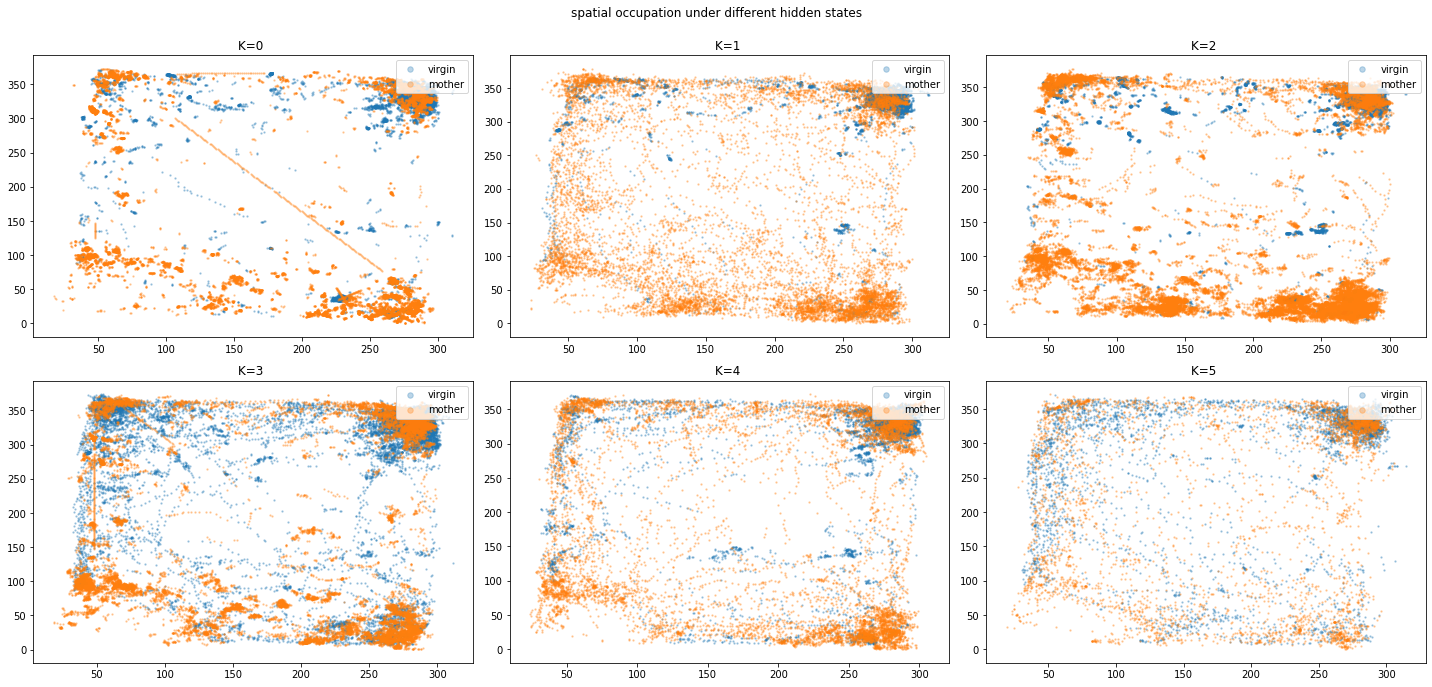

In [131]:
plot_data_condition_on_all_z(data, z, K, size=2, alpha=0.3)
plt.savefig(checkpoint_dir+"/distributions/spatial_occup_groundtruth.jpg", dpi=100)

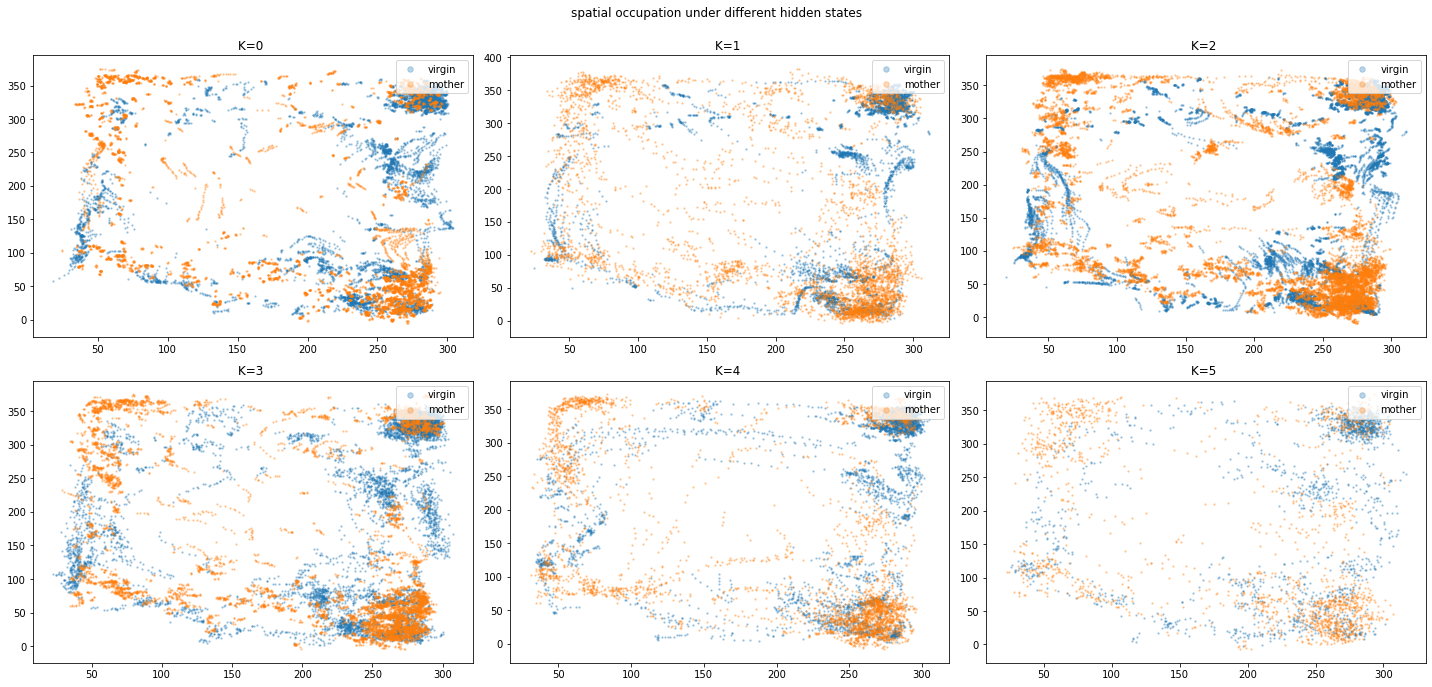

In [132]:
plot_data_condition_on_all_z(sample_x, sample_z, K, size=2, alpha=0.3)
plt.savefig(checkpoint_dir+"/distributions/spatial_occup_sample_x.jpg", dpi=100)

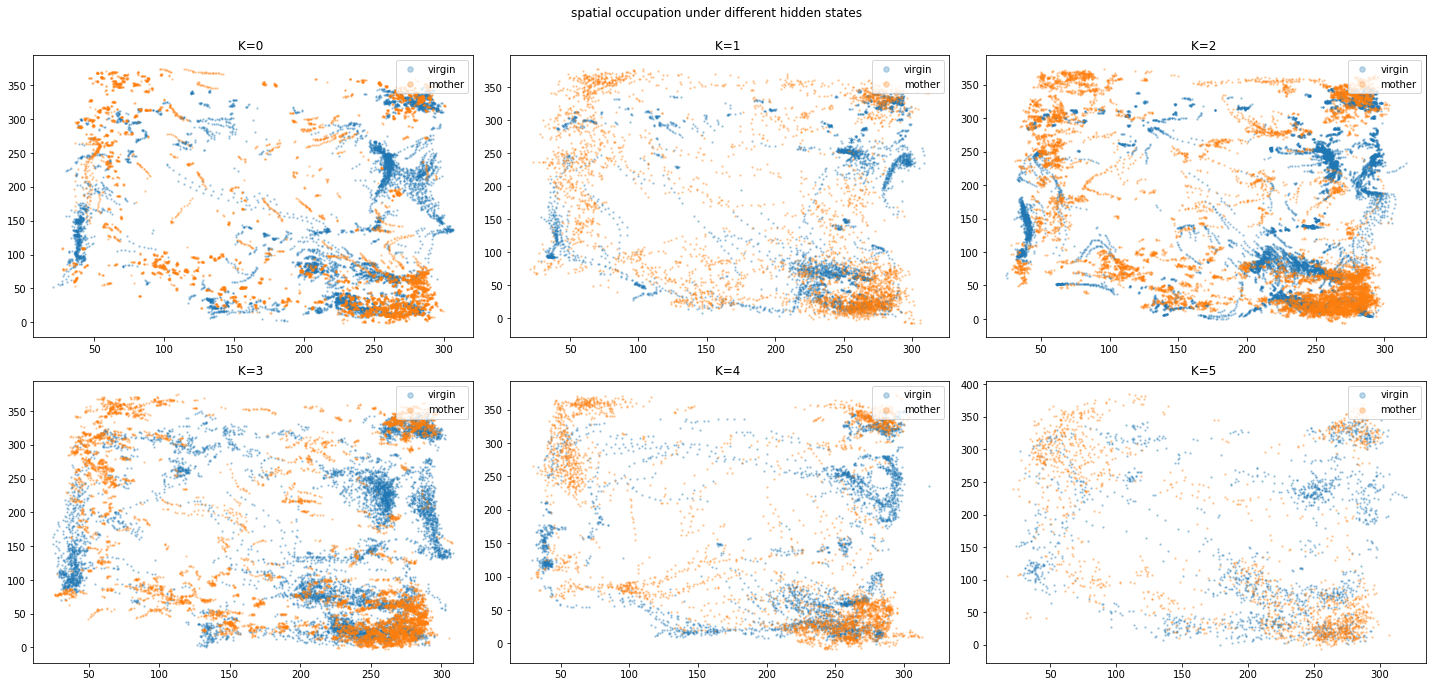

In [133]:
plot_data_condition_on_all_z(sample_x_center, sample_z_center, K, size=2, alpha=0.3)
plt.savefig(checkpoint_dir+"/distributions/spatial_occup_sample_x_center.jpg", dpi=100)

note: still need time dimension!

# spatial histogram

## first try sns

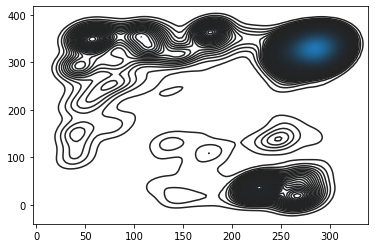

In [72]:
data_z1 = data.numpy()[z==1]
sns.kdeplot(data_z1[:, 0], data_z1[:, 1], n_levels=1000)

## then try count by grid

# adding time dimension

<IPython.core.display.Javascript object>


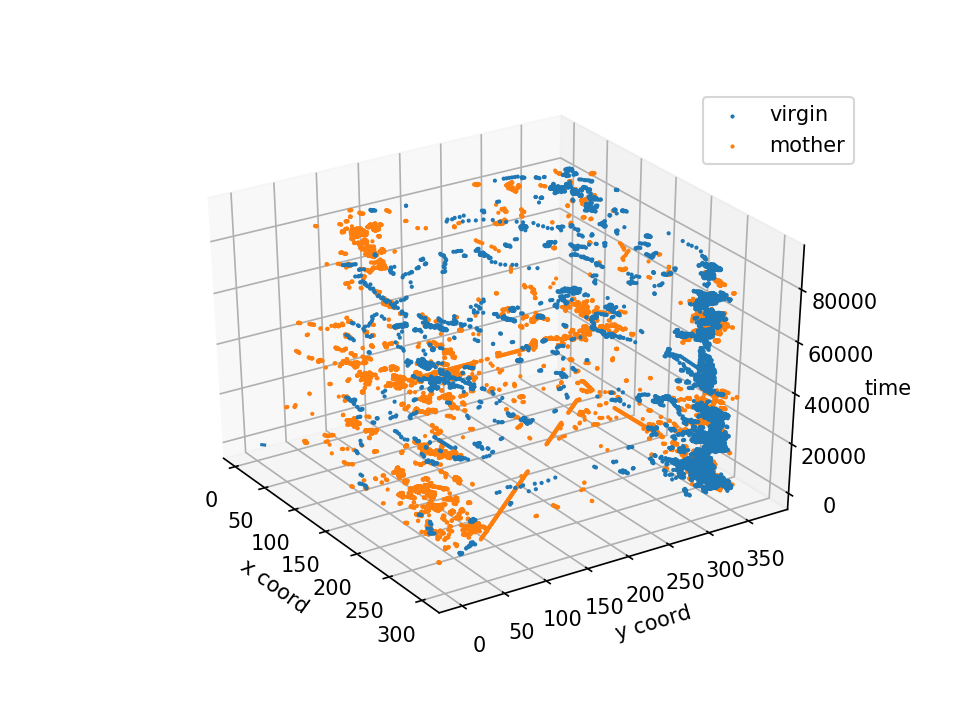

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 1
alpha = 1

time_z1 = np.where(z==1)[0]
data_z1 = data.numpy()[z==1]
ax.scatter(data_z1[:,0], data_z1[:,1], time_z1, s=size, alpha=alpha, label='virgin')
ax.scatter(data_z1[:,2], data_z1[:,3], time_z1, s=size, alpha=alpha, label='mother')

ax.set_xlabel('x coord')
ax.set_ylabel('y coord')
ax.set_zlabel('time')

plt.legend()

<IPython.core.display.Javascript object>


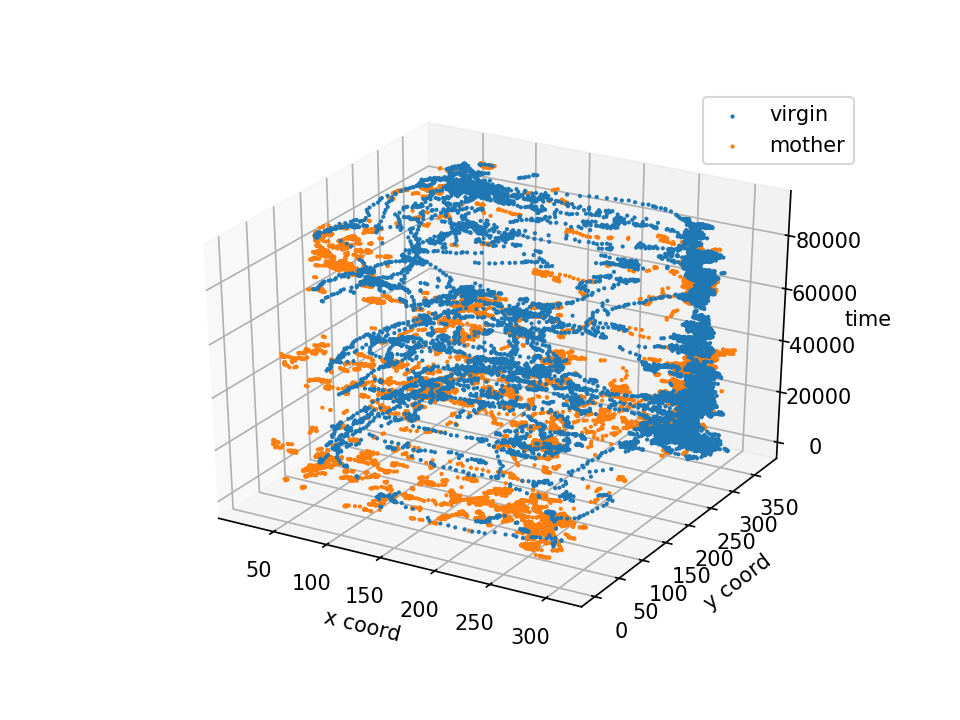

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 1
alpha = 1

time_z2 = np.where(z==2)[0]
data_z2 = data.numpy()[z==2]
ax.scatter(data_z2[:,0], data_z2[:,1], time_z2, s=size, alpha=alpha, label='virgin')
ax.scatter(data_z2[:,2], data_z2[:,3], time_z2, s=size, alpha=alpha, label='mother')

ax.set_xlabel('x coord')
ax.set_ylabel('y coord')
ax.set_zlabel('time')

plt.legend()

In [109]:
plt.close()

In [98]:
def plot_2d_time_plot_condition_on_z(data, z, k, time_start, time_end, size=0.5):
    """
    assume data is np.ndarray, and time_start and time_end is not None
    """
    data = data[time_start:time_end]
    z = z[time_start:time_end]
    time_zk = np.where(z==k)[0]
    data_zk = data[z==k]

    plt.scatter(time_zk, data_zk[:,0], label='virgin x', s=size)
    plt.scatter(time_zk, data_zk[:,1], label='virgin y', s=size)

    plt.scatter(time_zk, data_zk[:,2], label='mother x', s=size)
    plt.scatter(time_zk, data_zk[:,3], label='mother y', s=size)
    
    plt.title('k={}'.format(k), x=-0.03,y=0.3, fontsize=20)

    lgnd = plt.legend(loc='upper right', scatterpoints=1)
    for i in range(4):
        lgnd.legendHandles[i]._sizes = [30]

In [99]:
def plot_2d_time_plot_condition_on_all_zs(data, z, K, title, time_start=None, time_end=None, size=0.5):
    if isinstance(data, torch.Tensor):
        data = data.numpy()
        
    T, _ = data.shape
    time_start = time_start if time_start else 0
    time_end = time_end if time_end else T
    
    plt.figure(figsize=(30, 2*K))
    if title is not None:
        plt.suptitle(title)
    
    for k in range(K):
        plt.subplot(K,1,k+1)
        plot_2d_time_plot_condition_on_z(data, z, k, time_start, time_end, size)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        

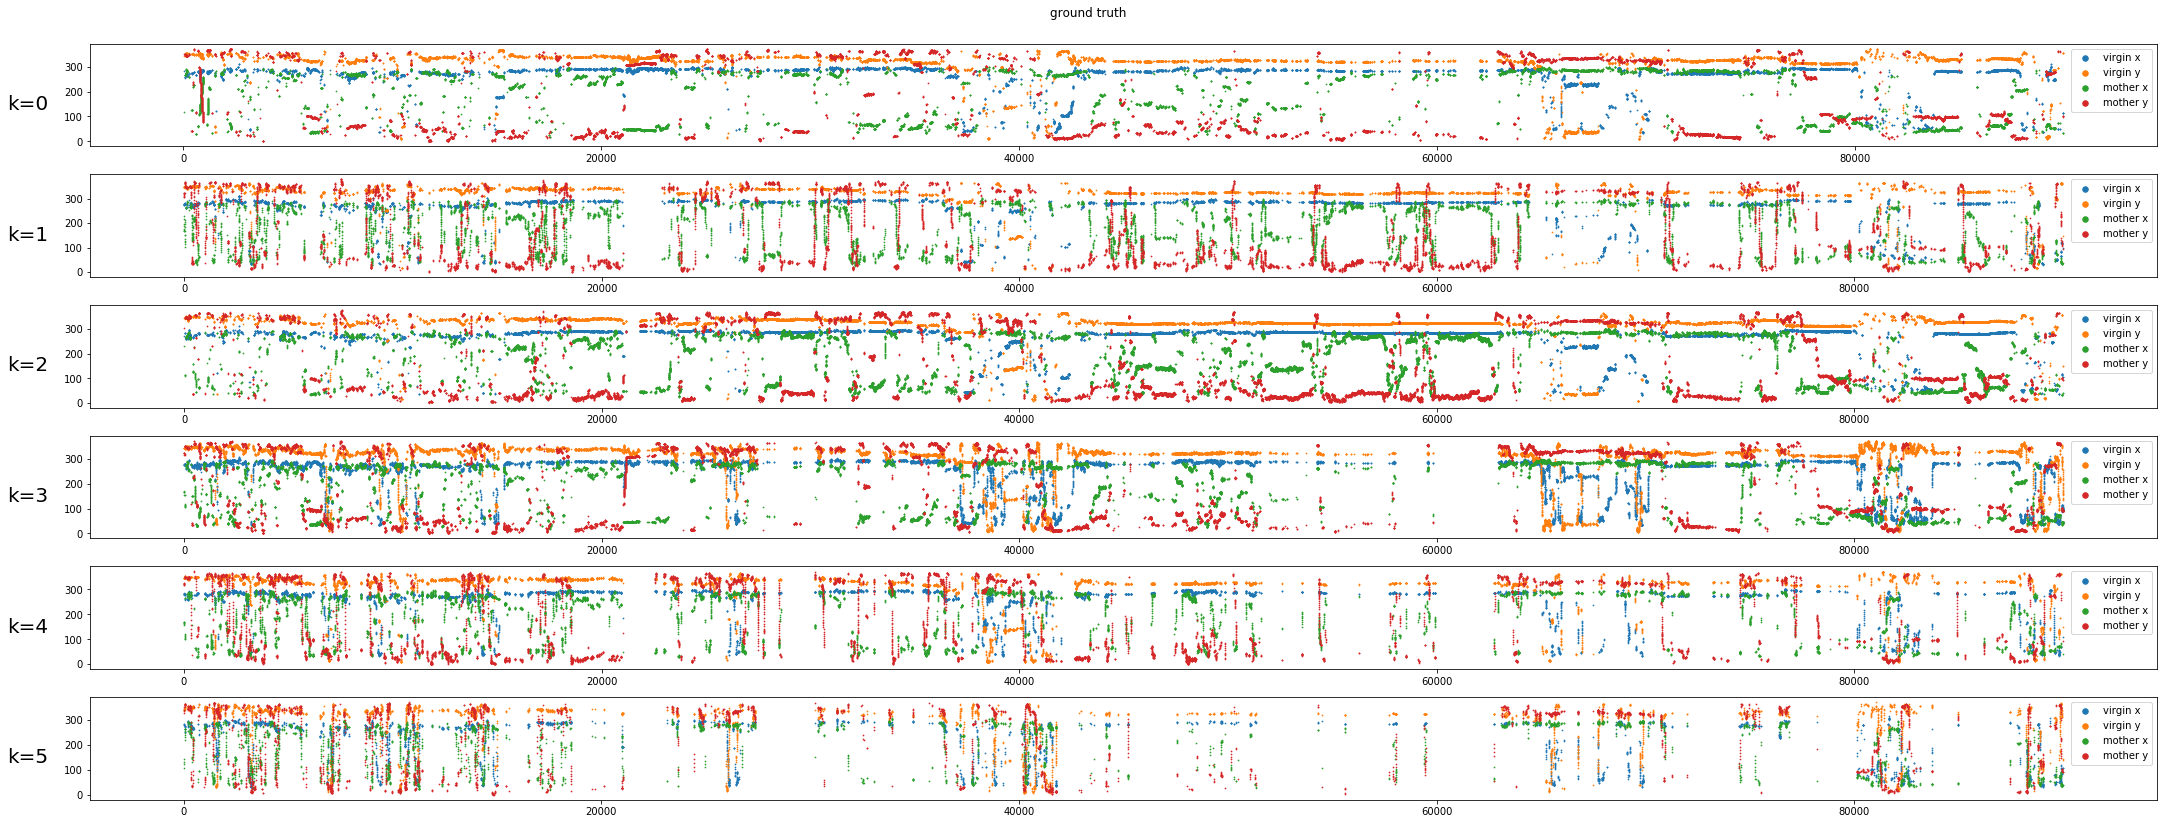

In [134]:
plot_2d_time_plot_condition_on_all_zs(data, z, K, title='ground truth')
plt.savefig(checkpoint_dir+"/distributions/4traces_groundtruth.jpg", dpi=100)

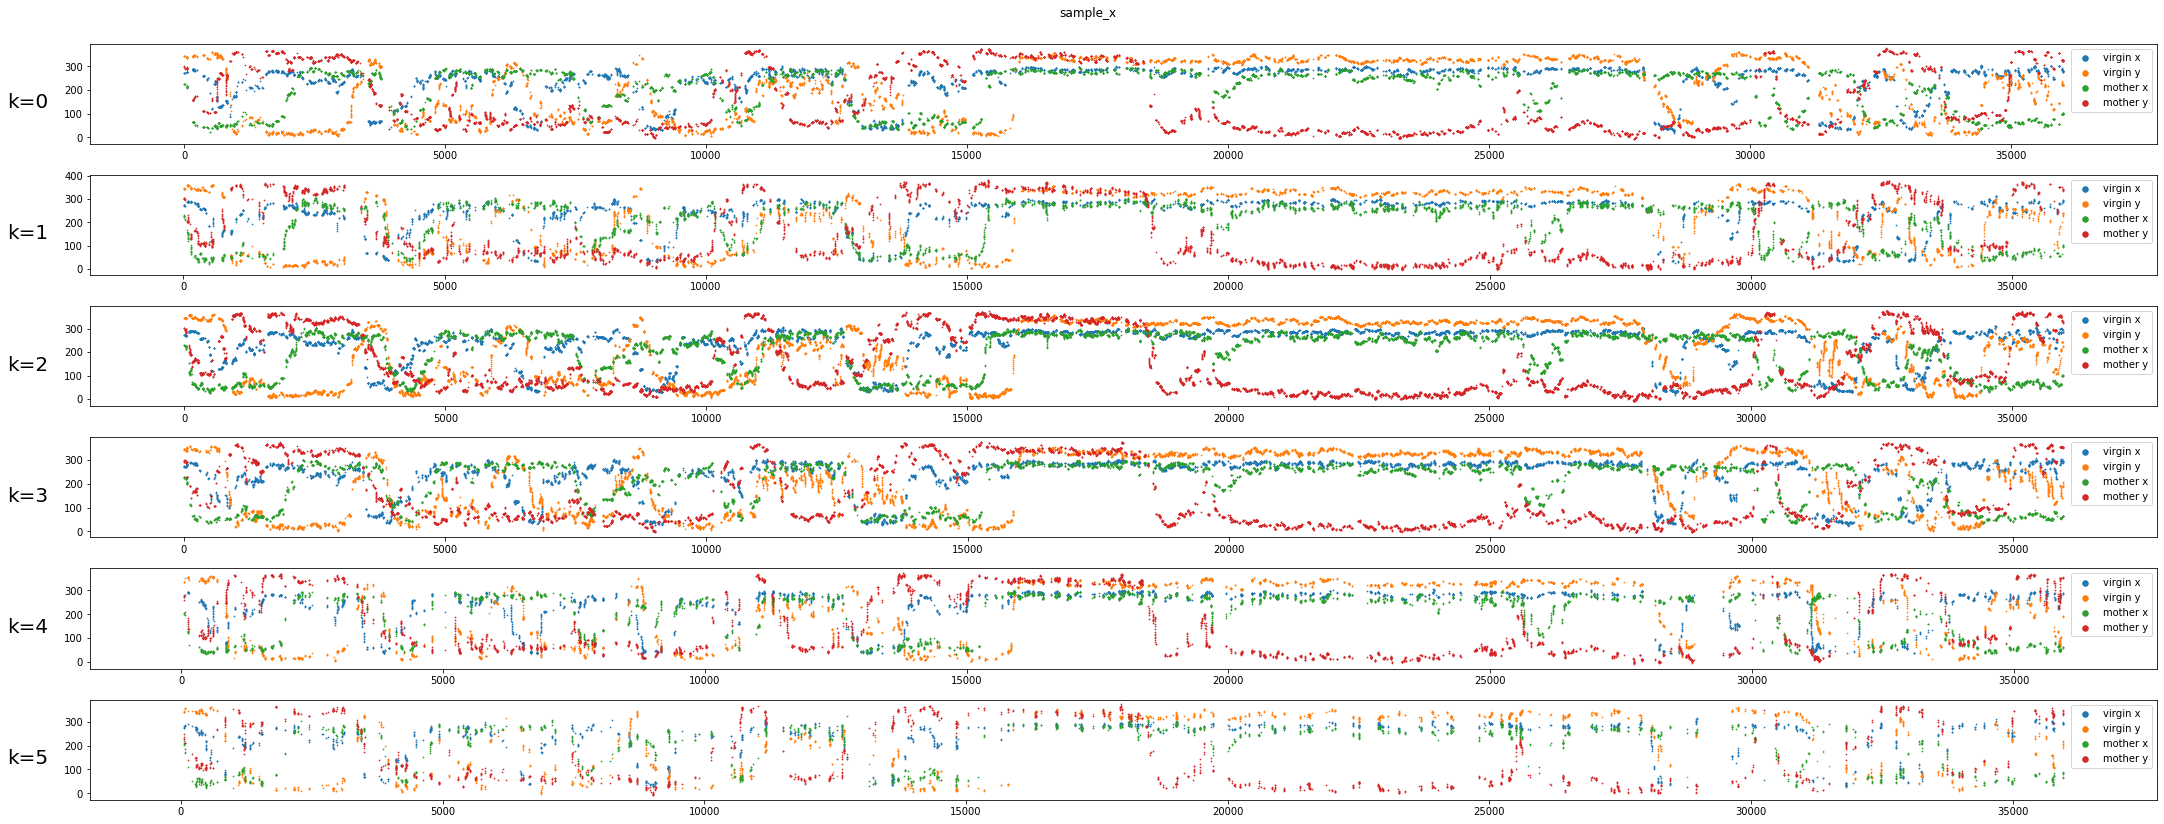

In [135]:
plot_2d_time_plot_condition_on_all_zs(sample_x, sample_z, K, title='sample_x')
plt.savefig(checkpoint_dir+"/distributions/4traces_sample_x.jpg", dpi=100)

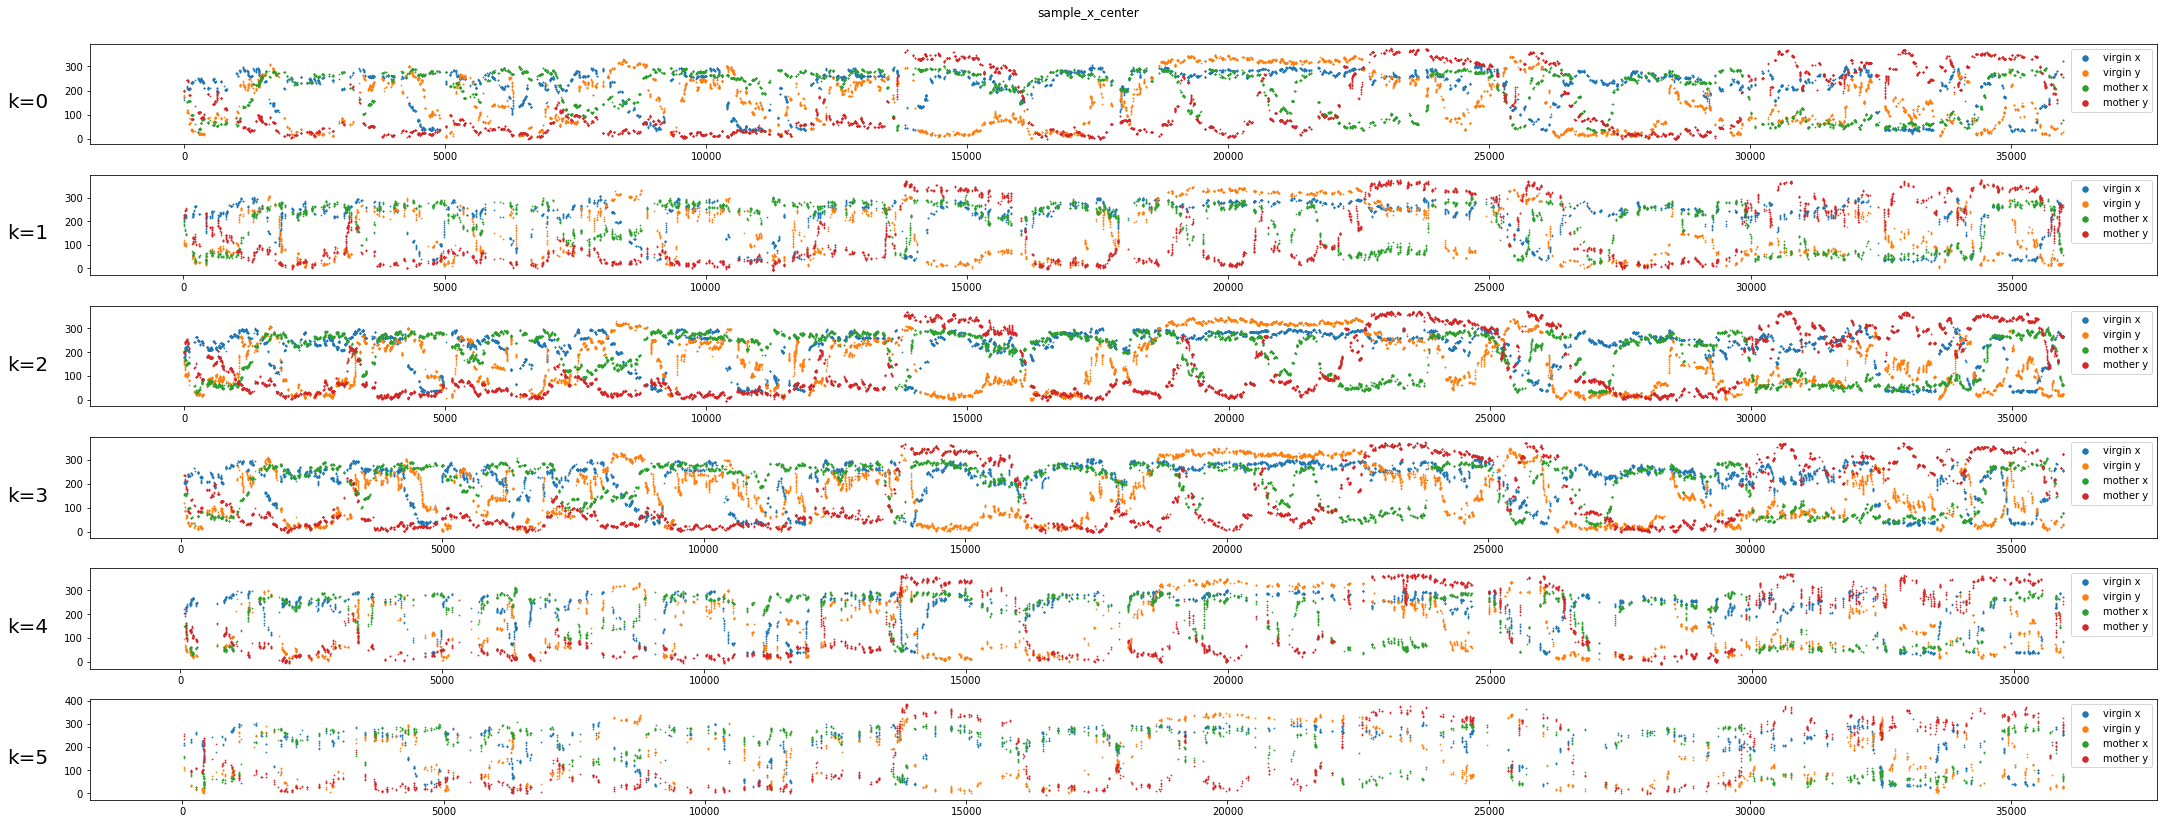

In [136]:
plot_2d_time_plot_condition_on_all_zs(sample_x_center, sample_z_center, K, title='sample_x_center')
plt.savefig(checkpoint_dir+"/distributions/4traces_sample_x_center.jpg", dpi=100)